# LSTM

## 0. Data Load

In [79]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import os
os.chdir('/content/drive/MyDrive/기상청/데이터')

In [2]:
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
from tqdm.notebook import tqdm
tqdm.pandas()

import random
from functools import reduce

import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
%matplotlib inline

rc('font', family='MalgunGothic')
plt.rcParams['axes.unicode_minus'] = False

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
%%time
df_st = pd.read_csv('stationary_causality.csv', encoding='CP949')
df_final = pd.read_csv('final_0619.csv', encoding='CP949')

CPU times: user 22.3 s, sys: 4.76 s, total: 27.1 s
Wall time: 34.7 s


In [11]:
df_st.head(2)

,sm_cat,avg_ta,hm_max,max_pa,max_ta,min_ta,PM10,PM25,avg_ws,sum_ss_hr,total
0,가스온수기,None,None,None,None,None,causality,None,None,None,1
1,가자미,causality,None,None,None,None,None,None,None,None,1


In [12]:
df_final.head(2)

,date,sex,big_cat,sm_cat,qty,ratio,오늘날씨,미세먼지,오늘 비,기상정보,태풍정보,avg_ta,max_ta,min_ta,rn_day,rn_hr1,avg_ws,PM10,PM25,hm_max,sum_ss_hr,max_pa,공휴일여부,주말여부,연_2019,월_2,월_3,월_4,월_5,월_6,월_7,월_8,월_9,월_10,월_11,월_12,분기_2,분기_3,분기_4,요일_1,요일_2,요일_3,요일_4,요일_5,요일_6,봄,여름,가을,겨울,age_20,age_30,age_40,age_50
0,2018-01-01,1,식품,가공란,37.0,0.0,10.69387,4.09137,0.0,0.00000,0.04440,0.885198,5.464146,-2.88074,0.0,0.0,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
1,2018-01-01,1,식품,가공란,16.0,0.0,12.42969,6.35294,0.0,0.51282,0.42417,0.885198,5.464146,-2.88074,0.0,0.0,2.157094,44.015611,21.477208,61.923313,52.276365,1020.592385,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0


In [6]:
df_st['sm_cat'].nunique()

130

In [7]:
df_st['sm_cat'].unique()

array(['가스온수기', '가자미', '감/홍시', '감말랭이', '갓김치', '건강즙/녹용', '건어물 멸치',
       '건어물 황태', '건자두', '견과류', '견과류 땅콩', '견과류 마카다미아', '견과류 잣/은행',
       '견과류 캐슈넛', '견과류 호두', '계란', '공기정화 용품', '공기청정기', '곶감/반건시',
       '과채 음료/주스', '기능성 링클케어 화장품', '기능성 영양보습 화장품', '기초 화장용 에센스',
       '기초 화장용 오일/앰플', '기타 농산물', '기타 한방/환제품', '나물', '남성 메이크업', '남성 스킨',
       '남성 에센스', '남성 크림', '남성 클렌징', '냉풍기', '네일 메이크업 용품', '네일리무버', '네일세트',
       '네일아트', '네일컬러', '네일케어', '녹차', '닭 양념육', '더치커피', '도라지/더덕', '돈풍기',
       '랍스타', '레몬/자몽', '린스', '립앤아이 리무버', '멀티형 에어컨', '메이크업 박스', '무/배추',
       '바나나/파인애플/망고', '바디 세트', '바디케어용 때비누', '바디케어용 슬리밍', '반건조고구마', '반찬류',
       '배/포도/과일즙', '백김치', '베이스 메이크업 세트', '베이스 메이크업용 BB크림',
       '베이스 메이크업용 CC크림', '베이스 메이크업용 메이크업베이스', '베이스 메이크업용 컨실러',
       '베이스 메이크업용 쿠션팩트', '벽걸이형 냉온풍기', '보일러', '뷰티 속눈썹/쌍꺼풀', '뷰티용 기름종이',
       '뷰티용 뷰러', '뷰티용 여드름압출기', '삼치', '색조 메이크업 립글로스', '색조 메이크업 립스틱',
       '색조 메이크업 마스카라', '색조 메이크업 볼터치', '색조 메이크업 속눈썹영양제',
       '색조 메이크업 쉐딩/하이라이터', '색조 메이크업 아이라이너', '생닭/닭부분육', '생선류'

## 1. Data Preprocessing

In [7]:
df_filter = df_final[df_final.sm_cat.isin(df_st['sm_cat'])].reset_index(drop=True)

In [8]:
df_lstm = df_filter.copy()

In [9]:
# 일자별 데이터 생성
df_lstm = df_lstm.groupby(['date','sm_cat']).sum().reset_index()

In [10]:
# 인덱스를 date로
df_lstm.index = pd.to_datetime(df_lstm['date'], format='%Y-%m-%d')

In [11]:
df_lstm.head(2)

,date,sm_cat,sex,qty,ratio,오늘날씨,미세먼지,오늘 비,기상정보,태풍정보,avg_ta,max_ta,min_ta,rn_day,rn_hr1,avg_ws,PM10,PM25,hm_max,sum_ss_hr,max_pa,공휴일여부,주말여부,연_2019,월_2,월_3,월_4,월_5,월_6,월_7,월_8,월_9,월_10,월_11,월_12,분기_2,분기_3,분기_4,요일_1,요일_2,요일_3,요일_4,요일_5,요일_6,봄,여름,가을,겨울,age_20,age_30,age_40,age_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01,2018-01-01,가스온수기,4,0.0,138.84683,116.97229,47.93916,1.51904,9.22413,1.66104,7.966781,49.177312,-25.926656,0.0,0.0,19.413844,396.140500,193.294868,557.309813,470.487281,9185.331469,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,2,2,2,1
2018-01-01,2018-01-01,가자미,5,21.0,21.88916,128.66309,52.47266,2.73855,10.13322,1.66104,8.851979,54.641458,-28.807396,0.0,0.0,21.570938,440.156111,214.772075,619.233125,522.763646,10205.923854,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,2,2,2,2


In [19]:
df_lstm.columns

Index(['date', 'sm_cat', 'sex', 'qty', 'ratio', '오늘날씨', '미세먼지', '오늘 비', '기상정보',
       '태풍정보', 'avg_ta', 'max_ta', 'min_ta', 'rn_day', 'rn_hr1', 'avg_ws',
       'PM10', 'PM25', 'hm_max', 'sum_ss_hr', 'max_pa', '공휴일여부', '주말여부',
       '연_2019', '월_2', '월_3', '월_4', '월_5', '월_6', '월_7', '월_8', '월_9',
       '월_10', '월_11', '월_12', '분기_2', '분기_3', '분기_4', '요일_1', '요일_2', '요일_3',
       '요일_4', '요일_5', '요일_6', '봄', '여름', '가을', '겨울', 'age_20', 'age_30',
       'age_40', 'age_50'],
      dtype='object')

In [20]:
df_lstm.sm_cat.unique()

array(['가스온수기', '가자미', '감/홍시', '감말랭이', '갓김치', '건강즙/녹용', '건어물 멸치',
       '건어물 황태', '건자두', '견과류', '견과류 땅콩', '견과류 마카다미아', '견과류 잣/은행',
       '견과류 캐슈넛', '견과류 호두', '계란', '공기정화 용품', '공기청정기', '곶감/반건시',
       '과채 음료/주스', '기능성 링클케어 화장품', '기능성 영양보습 화장품', '기초 화장용 에센스',
       '기초 화장용 오일/앰플', '기타 농산물', '기타 한방/환제품', '나물', '남성 메이크업', '남성 스킨',
       '남성 에센스', '남성 크림', '남성 클렌징', '냉풍기', '네일 메이크업 용품', '네일리무버', '네일세트',
       '네일아트', '네일컬러', '네일케어', '녹차', '닭 양념육', '더치커피', '도라지/더덕', '돈풍기',
       '랍스타', '레몬/자몽', '린스', '립앤아이 리무버', '메이크업 박스', '무/배추', '바나나/파인애플/망고',
       '바디 세트', '바디케어용 때비누', '바디케어용 슬리밍', '반건조고구마', '반찬류', '배/포도/과일즙',
       '백김치', '베이스 메이크업 세트', '베이스 메이크업용 BB크림', '베이스 메이크업용 CC크림',
       '베이스 메이크업용 메이크업베이스', '베이스 메이크업용 컨실러', '베이스 메이크업용 쿠션팩트',
       '벽걸이형 냉온풍기', '보일러', '뷰티 속눈썹/쌍꺼풀', '뷰티용 기름종이', '뷰티용 뷰러',
       '뷰티용 여드름압출기', '삼치', '색조 메이크업 립글로스', '색조 메이크업 립스틱', '색조 메이크업 마스카라',
       '색조 메이크업 볼터치', '색조 메이크업 속눈썹영양제', '색조 메이크업 쉐딩/하이라이터',
       '색조 메이크업 아이라이너', '생닭/닭부분육', '생선류', '생수', '샤워

findfont: Font family ['MalgunGothic'] not found. Falling back to DejaVu Sans.


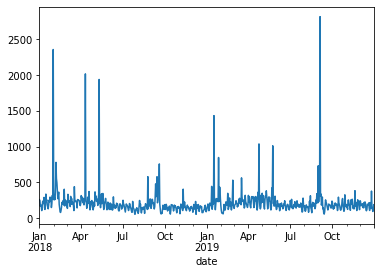

In [21]:
df_lstm[df_lstm['sm_cat']=='견과류']['qty'].plot()

In [12]:
# 각 소분류에 대하여
df_ex = df_lstm[df_lstm['sm_cat']=='견과류']

In [13]:
# 사용할 변수만 선택
df_use = df_ex[['qty', 'ratio','오늘날씨','미세먼지','오늘 비', '기상정보', '태풍정보', 'avg_ta', 'max_ta', 'min_ta', 'rn_day',
       'rn_hr1', 'avg_ws', 'PM10', 'PM25', 'hm_max', 'sum_ss_hr', 'max_pa', '공휴일여부', '주말여부']]

In [14]:
df_use.head(2)

,qty,ratio,오늘날씨,미세먼지,오늘 비,기상정보,태풍정보,avg_ta,max_ta,min_ta,rn_day,rn_hr1,avg_ws,PM10,PM25,hm_max,sum_ss_hr,max_pa,공휴일여부,주말여부
date,,,,,,,,,,,,,,,,,,,,
2018-01-01,256.0,319.81828,128.66309,52.47266,2.73855,10.13322,1.66104,8.851979,54.641458,-28.807396,0.0,0.0,21.570938,440.156111,214.772075,619.233125,522.763646,10205.923854,10,0
2018-01-02,247.0,323.78755,158.62925,48.07639,0.78435,14.97471,1.81647,12.088958,60.143854,-31.351667,0.0,0.0,19.036042,591.794872,338.368265,741.697813,379.966771,10215.248021,0,0


In [ ]:
df_use.columns

Index(['qty', 'ratio', '오늘날씨', '미세먼지', '오늘 비', '기상정보', '태풍정보', 'avg_ta',
       'max_ta', 'min_ta', 'rn_day', 'rn_hr1', 'avg_ws', 'PM10', 'PM25',
       'hm_max', 'sum_ss_hr', 'max_pa', '공휴일여부', '주말여부'],
      dtype='object')

In [15]:
# 스케일링
scaler = MinMaxScaler(feature_range=(0, 1))
df_scale = scaler.fit_transform(df_use)

In [59]:
# specify the number of lag hours
n_hours = 3
n_features = 20

In [42]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols[::-1], axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [43]:
df_use.head(2)

,qty,ratio,오늘날씨,미세먼지,오늘 비,기상정보,태풍정보,avg_ta,max_ta,min_ta,rn_day,rn_hr1,avg_ws,PM10,PM25,hm_max,sum_ss_hr,max_pa,공휴일여부,주말여부
date,,,,,,,,,,,,,,,,,,,,
2018-01-01,256.0,319.81828,128.66309,52.47266,2.73855,10.13322,1.66104,8.851979,54.641458,-28.807396,0.0,0.0,21.570938,440.156111,214.772075,619.233125,522.763646,10205.923854,10,0
2018-01-02,247.0,323.78755,158.62925,48.07639,0.78435,14.97471,1.81647,12.088958,60.143854,-31.351667,0.0,0.0,19.036042,591.794872,338.368265,741.697813,379.966771,10215.248021,0,0


In [19]:
pd.DataFrame(df_scale).head(4)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.073391,0.216013,0.079963,0.051023,0.002881,0.002310,0.001910,0.282275,0.293697,0.273628,0.0,0.0,0.275783,0.300410,0.211566,0.380654,0.661924,0.975454,1.0,0.0
1,0.070137,0.221946,0.113014,0.046317,0.000825,0.007190,0.002088,0.290785,0.307831,0.266960,0.0,0.0,0.217126,0.427235,0.356830,0.596928,0.481114,0.980279,0.0,0.0
2,0.040492,0.274614,0.082063,0.019729,0.001231,0.011883,0.001744,0.238009,0.236466,0.254262,0.0,0.0,0.383724,0.206255,0.173547,0.334510,0.673833,0.989349,0.0,0.0
3,0.048084,0.287646,0.066988,0.020696,0.001120,0.011541,0.001859,0.230726,0.213595,0.227607,0.0,0.0,0.203039,0.255830,0.229996,0.416653,0.426800,0.980356,0.0,0.0


In [63]:
# (n) x (m) -> (n-1) x (2m)
# to include the current and the 1-step look-back values
df_reframe = series_to_supervised(df_scale, n_hours, 1)
print(df_reframe.shape)
df_reframe.head(2)

(727, 80)


,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var9(t-3),var10(t-3),var11(t-3),var12(t-3),var13(t-3),var14(t-3),var15(t-3),var16(t-3),var17(t-3),var18(t-3),var19(t-3),var20(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var8(t-2),var9(t-2),var10(t-2),var11(t-2),var12(t-2),var13(t-2),var14(t-2),var15(t-2),var16(t-2),var17(t-2),var18(t-2),var19(t-2),var20(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1),var16(t-1),var17(t-1),var18(t-1),var19(t-1),var20(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t),var13(t),var14(t),var15(t),var16(t),var17(t),var18(t),var19(t),var20(t)
3,0.048084,0.287646,0.066988,0.020696,0.001120,0.011541,0.001859,0.230726,0.213595,0.227607,0.000000,0.00000,0.203039,0.255830,0.229996,0.416653,0.426800,0.980356,0.0,0.0,0.040492,0.274614,0.082063,0.019729,0.001231,0.011883,0.001744,0.238009,0.236466,0.254262,0.0,0.0,0.383724,0.206255,0.173547,0.334510,0.673833,0.989349,0.0,0.0,0.070137,0.221946,0.113014,0.046317,0.000825,0.007190,0.002088,0.290785,0.307831,0.266960,0.0,0.0,0.217126,0.427235,0.356830,0.596928,0.481114,0.980279,0.0,0.0,0.073391,0.216013,0.079963,0.051023,0.002881,0.00231,0.001910,0.282275,0.293697,0.273628,0.0,0.0,0.275783,0.300410,0.211566,0.380654,0.661924,0.975454,1.0,0.0
4,0.038684,0.184086,0.062533,0.029484,0.002674,0.005236,0.004388,0.274374,0.283160,0.289555,0.004387,0.00553,0.304440,0.318276,0.320964,0.554148,0.511586,0.944061,0.0,0.0,0.048084,0.287646,0.066988,0.020696,0.001120,0.011541,0.001859,0.230726,0.213595,0.227607,0.0,0.0,0.203039,0.255830,0.229996,0.416653,0.426800,0.980356,0.0,0.0,0.040492,0.274614,0.082063,0.019729,0.001231,0.011883,0.001744,0.238009,0.236466,0.254262,0.0,0.0,0.383724,0.206255,0.173547,0.334510,0.673833,0.989349,0.0,0.0,0.070137,0.221946,0.113014,0.046317,0.000825,0.00719,0.002088,0.290785,0.307831,0.266960,0.0,0.0,0.217126,0.427235,0.356830,0.596928,0.481114,0.980279,0.0,0.0


In [68]:
# split into train and test sets
values = df_reframe.values
n_train_hours = 730 - 60
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(670, 60) 670 (670,)
(670, 3, 20) (670,) (57, 3, 20) (57,)


## 2. LSTM

Epoch 1/50
10/10 - 3s - loss: 0.1220 - val_loss: 0.0472
Epoch 2/50
10/10 - 0s - loss: 0.0571 - val_loss: 0.0511
Epoch 3/50
10/10 - 0s - loss: 0.0375 - val_loss: 0.0166
Epoch 4/50
10/10 - 0s - loss: 0.0339 - val_loss: 0.0150
Epoch 5/50
10/10 - 0s - loss: 0.0341 - val_loss: 0.0159
Epoch 6/50
10/10 - 0s - loss: 0.0284 - val_loss: 0.0149
Epoch 7/50
10/10 - 0s - loss: 0.0291 - val_loss: 0.0153
Epoch 8/50
10/10 - 0s - loss: 0.0280 - val_loss: 0.0151
Epoch 9/50
10/10 - 0s - loss: 0.0258 - val_loss: 0.0174
Epoch 10/50
10/10 - 0s - loss: 0.0253 - val_loss: 0.0194
Epoch 11/50
10/10 - 0s - loss: 0.0262 - val_loss: 0.0167
Epoch 12/50
10/10 - 0s - loss: 0.0269 - val_loss: 0.0149
Epoch 13/50
10/10 - 0s - loss: 0.0273 - val_loss: 0.0155
Epoch 14/50
10/10 - 0s - loss: 0.0263 - val_loss: 0.0168
Epoch 15/50
10/10 - 0s - loss: 0.0261 - val_loss: 0.0185
Epoch 16/50
10/10 - 0s - loss: 0.0270 - val_loss: 0.0249
Epoch 17/50
10/10 - 0s - loss: 0.0307 - val_loss: 0.0269
Epoch 18/50
10/10 - 0s - loss: 0.0326 - 

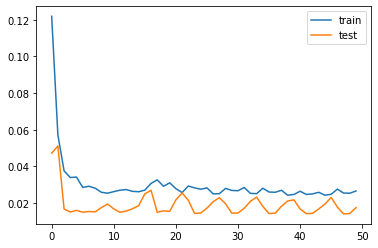

In [65]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [69]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 59.794


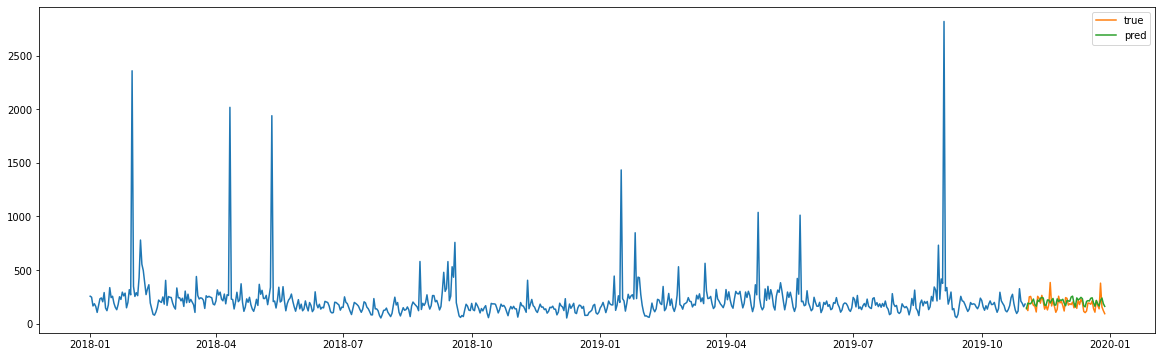

In [70]:
plt.figure(figsize=(20,6))
plt.plot(df_use.iloc[:n_train_hours,:]['qty'])
plt.plot(df_use.iloc[n_train_hours:-n_hours,:].index, inv_y, label='true')
plt.plot(df_use.iloc[n_train_hours:-n_hours,:].index, inv_yhat, label='pred')
plt.legend()
plt.show()

* 코드: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
* 설명: https://qwerty1434.github.io/%EB%8B%A4%EC%A4%91%EB%B3%80%EC%88%98%EC%9D%98-%ED%83%80%EC%9E%84%EC%8B%9C%EB%A6%AC%EC%A6%88-LSTM%EC%97%B0%EC%8A%B5
* 디버깅: https://datascience.stackexchange.com/questions/22488/value-error-operands-could-not-be-broadcast-together-with-shapes-lstm

## 3. Function

In [4]:
df_filter = df_final[df_final.sm_cat.isin(df_st['sm_cat'])].reset_index(drop=True)
df_lstm = df_filter.copy()
df_lstm = df_lstm.groupby(['date','sm_cat']).sum().reset_index()
df_lstm.index = pd.to_datetime(df_lstm['date'], format='%Y-%m-%d')

In [5]:
def MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 

In [6]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [7]:
def sm_cat_lstm(smcat):
    print('소분류: ', smcat)
    try:
        ## 데이터 전처리 ##
        # 각 소분류에 대하여
        df_ex = df_lstm[df_lstm['sm_cat']==smcat]
        # 사용할 변수만 선택
        df_use = df_ex[['qty', 'ratio','오늘날씨','미세먼지','오늘 비', '기상정보', '태풍정보', 'avg_ta', 'max_ta', 'min_ta', 'rn_day',
                        'rn_hr1', 'avg_ws', 'PM10', 'PM25', 'hm_max', 'sum_ss_hr', 'max_pa', '공휴일여부', '주말여부']]
        # 스케일링
        scaler = MinMaxScaler(feature_range=(0, 1))
        df_scale = scaler.fit_transform(df_use)
        # 데이터 프레임
        n_hours = 3; n_features = 20
        df_reframe = series_to_supervised(df_scale, n_hours, 1)
        # 트테분리
        values = df_reframe.values
        n_train_hours = 730 - 90
        train = values[:n_train_hours, :]
        test = values[n_train_hours:, :]
        # split into input and outputs
        n_obs = n_hours * n_features
        train_X, train_y = train[:, :n_obs], train[:, -n_features]
        test_X, test_y = test[:, :n_obs], test[:, -n_features]
        # reshape input to be 3D [samples, timesteps, features]
        train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
        test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
        
        ## 모델링 ##
        # design network
        model = Sequential()
        model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dense(1))
        model.compile(loss='mae', optimizer='adam')
        # fit network
        history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
        # plot history
        plt.figure(figsize=(15,6))
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.legend()
        plt.title('loss')
        plt.show()
        # make a prediction
        yhat = model.predict(test_X)
        test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
        # invert scaling for forecast
        inv_yhat = np.concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
        inv_yhat = scaler.inverse_transform(inv_yhat)
        inv_yhat = inv_yhat[:,0]
        # invert scaling for actual
        test_y = test_y.reshape((len(test_y), 1))
        inv_y = np.concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)
        inv_y = scaler.inverse_transform(inv_y)
        inv_y = inv_y[:,0]
        # calculate RMSE
        mse = mean_squared_error(inv_y, inv_yhat)
        rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
        mape = MAPE(inv_y, inv_yhat)
        
        # plot predict
        plt.figure(figsize=(15,6))
        plt.plot(df_use.iloc[:n_train_hours,:]['qty'])
        plt.plot(df_use.iloc[n_train_hours:-n_hours,:].index, inv_y, label='true')
        plt.plot(df_use.iloc[n_train_hours:-n_hours,:].index, inv_yhat, label='pred')
        plt.legend()
        plt.show()
        print('Test MSE: %.3f' % mse)
        print('Test RMSE: %.3f' % rmse)
        print('Test MAPE: %.3f' % mape)
        print('=========='*10)
    except:
        pass

In [81]:
for sm_cats in df_lstm['sm_cat']:
    sm_cat_lstm(sm_cats)

Output hidden; open in https://colab.research.google.com to view.

In [82]:
df_lstm['sm_cat'].unique()

array(['가스온수기', '가자미', '감/홍시', '감말랭이', '갓김치', '건강즙/녹용', '건어물 멸치',
       '건어물 황태', '건자두', '견과류', '견과류 땅콩', '견과류 마카다미아', '견과류 잣/은행',
       '견과류 캐슈넛', '견과류 호두', '계란', '공기정화 용품', '공기청정기', '곶감/반건시',
       '과채 음료/주스', '기능성 링클케어 화장품', '기능성 영양보습 화장품', '기초 화장용 에센스',
       '기초 화장용 오일/앰플', '기타 농산물', '기타 한방/환제품', '나물', '남성 메이크업', '남성 스킨',
       '남성 에센스', '남성 크림', '남성 클렌징', '냉풍기', '네일 메이크업 용품', '네일리무버', '네일세트',
       '네일아트', '네일컬러', '네일케어', '녹차', '닭 양념육', '더치커피', '도라지/더덕', '돈풍기',
       '랍스타', '레몬/자몽', '린스', '립앤아이 리무버', '메이크업 박스', '무/배추', '바나나/파인애플/망고',
       '바디 세트', '바디케어용 때비누', '바디케어용 슬리밍', '반건조고구마', '반찬류', '배/포도/과일즙',
       '백김치', '베이스 메이크업 세트', '베이스 메이크업용 BB크림', '베이스 메이크업용 CC크림',
       '베이스 메이크업용 메이크업베이스', '베이스 메이크업용 컨실러', '베이스 메이크업용 쿠션팩트',
       '벽걸이형 냉온풍기', '보일러', '뷰티 속눈썹/쌍꺼풀', '뷰티용 기름종이', '뷰티용 뷰러',
       '뷰티용 여드름압출기', '삼치', '색조 메이크업 립글로스', '색조 메이크업 립스틱', '색조 메이크업 마스카라',
       '색조 메이크업 볼터치', '색조 메이크업 속눈썹영양제', '색조 메이크업 쉐딩/하이라이터',
       '색조 메이크업 아이라이너', '생닭/닭부분육', '생선류', '생수', '샤워

In [8]:
for sm_cats in df_lstm['sm_cat'].unique():
    sm_cat_lstm(sm_cats)

Output hidden; open in https://colab.research.google.com to view.